# Compare SCF/SWE relationships to observations

## Observation
**Global EASE-Grid 8-day Blended SSM/I and MODIS Snow Cover, Version 1** (https://nsidc.org/data/NSIDC-0321/versions/1)

See more:
- https://github.com/mickaellalande/PhD/blob/master/Observations/NSIDC/nsidc0321_blended_ssmi_modis/scf_swe.ipynb
- https://github.com/mickaellalande/PhD/blob/master/Observations/NSIDC/nsidc0321_blended_ssmi_modis/nsidc0321_blended_ssmi_modis.ipynb

Mountainous areas with large topographic variability return **low mean SWE values**. Brightness temperatures in these areas may include mixed emission from deep snow on north-facing slopes, snow-free south-facing slopes, wind-scoured Alpine areas, etc.

## Snow Water Equivalent (SWE), snow density ($\rho_{snow}$), snow depth (d) relationship
$$
SWE = d \cdot \frac{\rho_{\text{snow}}}{\rho_{\text{water}}} \ [\text{m}] \simeq d \cdot \rho_{\text{snow}} \ [\text{mm}]
$$

$$
\rho_{\text{water}} = 997 \text{ kg} \cdot \text{m}^{-3} \simeq 1000 \text{ kg} \cdot \text{m}^{-3}
$$

## Parameterizations

- [Niu and Yang (2007)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2007JD008674): https://github.com/mickaellalande/PhD/blob/master/local/SCE_SWE_parametization/Niu2007.ipynb


$$
SCF = \tanh \frac{d}{2.5 \cdot z_{0g} \cdot \left( \frac{ \rho_{\text{snow}} }{ \rho_{\text{new}}} \right)^{m}} = \tanh \frac{ 50 \cdot d }{ 0.025 \cdot \rho_{\text{snow}} } \ (\text{in Orchidée}) = \tanh \frac{ 50 \cdot SWE \cdot \rho_{\text{water}} }{ 0.025 \cdot \rho_{\text{snow}}^2 }
$$

> - **In Orchidée for $frac_{\text{snow,veg}}$** (https://orchidas.lsce.ipsl.fr/dev/albedo/):    
>  - $z_{0g} = 0.01$ (ground roughness length)  
>  - $\rho_{\text{new}} = 50 \text{ kg} \cdot \text{m}^{-3}$ (density of the new snow, 100 in NY07)  
>  - $m = 1$ (empirical constant)
>
> - **Orchidée snow scheme**: [Wang et al. (2013)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/jgrd.50395)

- [Niu and Yang (2007)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2007JD008674) modified ([LMDZOR-STD-NY07-CUSTOM-200](https://github.com/mickaellalande/PhD/blob/master/Jean-Zay/SCA_parameterization/LMDZOR-STD-NY07-CUSTOM-200/NY07-CUSTOM-200_REF.ipynb)): https://github.com/mickaellalande/PhD/blob/master/local/SCE_SWE_parametization/Niu2007-std.ipynb

$$
SCF = \tanh \frac{ 50 \cdot d }{ 0.025 \cdot \rho_{\text{snow}} \left( 1 + \frac{\sigma_{topo}}{200} \right) }
$$


- [Swenson and Lawrence (2012)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2012JD018178) simplified (only depletion curve): https://github.com/mickaellalande/PhD/blob/master/local/SCE_SWE_parametization/Swenson2012.ipynb

$$
SCF = 1-\left[\frac{1}{\pi} \operatorname{acos}\left(2 \frac{W}{W_{\max }}-1\right)\right]^{N_{\text {melt}}}
$$

$$
N_{\text {melt}}=\frac{200}{\sigma_{\text {topo}}}
$$

- [Roesch et al. (2001)](https://link.springer.com/article/10.1007%2Fs003820100153) simplified (only moutaineous area without forest): https://github.com/mickaellalande/PhD/blob/master/local/SCE_SWE_parametization/Roesch2001.ipynb

$$
f_{s}=0.95 \cdot \tanh \left(100 \cdot S_{n}\right) \sqrt{\frac{1000 \cdot S_{n}}{1000 \cdot S_{n}+\epsilon+0.15 \sigma_{z}}}
$$


## Data access on CICLAD
Path on CICLAD: `/data/mlalande/NSIDC/nsidc0321_blended_ssmi_modis/`

## Python environment
conda env: new `phd_v3` (in `envs/phd`)

# Import modules

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
# sys.path.insert(1, '/home/mlalande/notebooks/utils') # to include my util file in previous directory
sys.path.insert(1, '/home/lalandmi/Dropbox/Thèse/notebooks/utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [2]:
xr.__version__

'0.16.0'

# Define paths

In [3]:
# CICLAD
# path = '/data/mlalande/NSIDC/nsidc0321_blended_ssmi_modis/'

# Local
path = '/home/lalandmi/data/nsidc0321_blended_ssmi_modis/'

# Get data

In [4]:
ds = xr.open_mfdataset(path+'/north/NL.*.nsidc0321v01.nc', combine='by_coords')

In [5]:
# ds

In [6]:
scf_with_mask = ds.SCA
swe_with_mask = ds.SWE

In [7]:
# scf_with_mask
# swe_with_mask

### SCF
 0          : no snow  
 1 to 100   : percent MODIS snow-covered area  
 -175       : no SCA, due to to cloud/fill/night  
 -200       : fixed value for corners  
 -250       : ocean  
 -300       : permanent ice sheets and large glaciers

### SWE
 \> 0       : SWE from deep microwave algorithm for 8-day period  
 0          : no snow  
 -100 to -1 : -1 * SWE from shallow microwave algorithm  
 -150       : missing microwave brightness temperatures  
 -200       : fixed value for corners  
 -250       : ocean  
 -300       : permanent ice sheets and large glaciers  
 -350       : no microwave SWE, but visible SCA > 25%

In [8]:
scf = scf_with_mask.where( (scf_with_mask >= 0) & (scf_with_mask <= 100) )

swe = swe_with_mask.where(swe_with_mask >= 0)
swe_from_mw_algo = -1 * swe_with_mask.where( (swe_with_mask >= -100) & (swe_with_mask <= -1) )

## Get std of topography at 25 km
http://www.temis.nl/data/gmted2010/

In [9]:
gmted = xr.open_dataset('/home/lalandmi/data/GMTED2010/GMTED2010_15n060_0250deg.nc')

In [10]:
std = gmted \
    .assign_coords({'nlat': gmted.latitude, 'nlon': gmted.longitude}) \
    .rename({'nlat': 'lat', 'nlon': 'lon'}) \
    .elevation_stddev

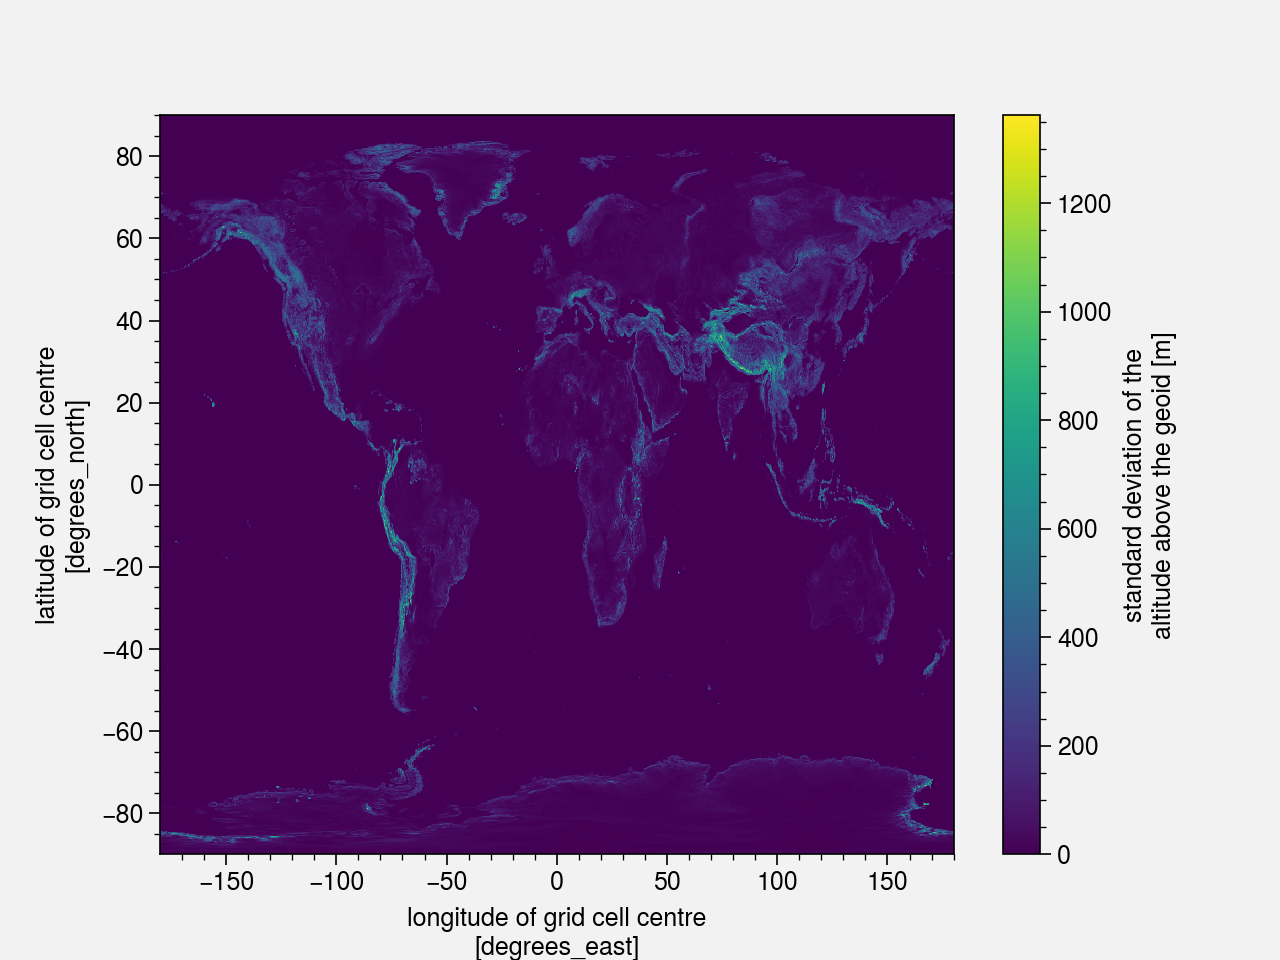

In [11]:
std.plot()

# Regrid on topo

In [12]:
scf_regrid = u.regrid(scf.rename({'longitude': 'lon', 'latitude': 'lat'}), std, 
                      globe=False, periodic=False)

Reuse existing file: bilinear_721x721_720x1440.nc


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [13]:
swe_regrid = u.regrid(swe.rename({'longitude': 'lon', 'latitude': 'lat'}), std, 
                      globe=False, periodic=False)

Reuse existing file: bilinear_721x721_720x1440.nc


/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


# Load data (/!\ 6Go /!\\)
Otherwise ignore this cell but it will be longer to make plots

In [ ]:
swe_regrid.load()
scf_regrid.load()

# Plot SCF/SWE relationship
For all months and all points / std < 200 / std > 200

3 domains:
- 'NH': Northern Hemisphere
- 'HMA': High Mountains of Asia
- 'NA': North America

Then compare to monthly average.

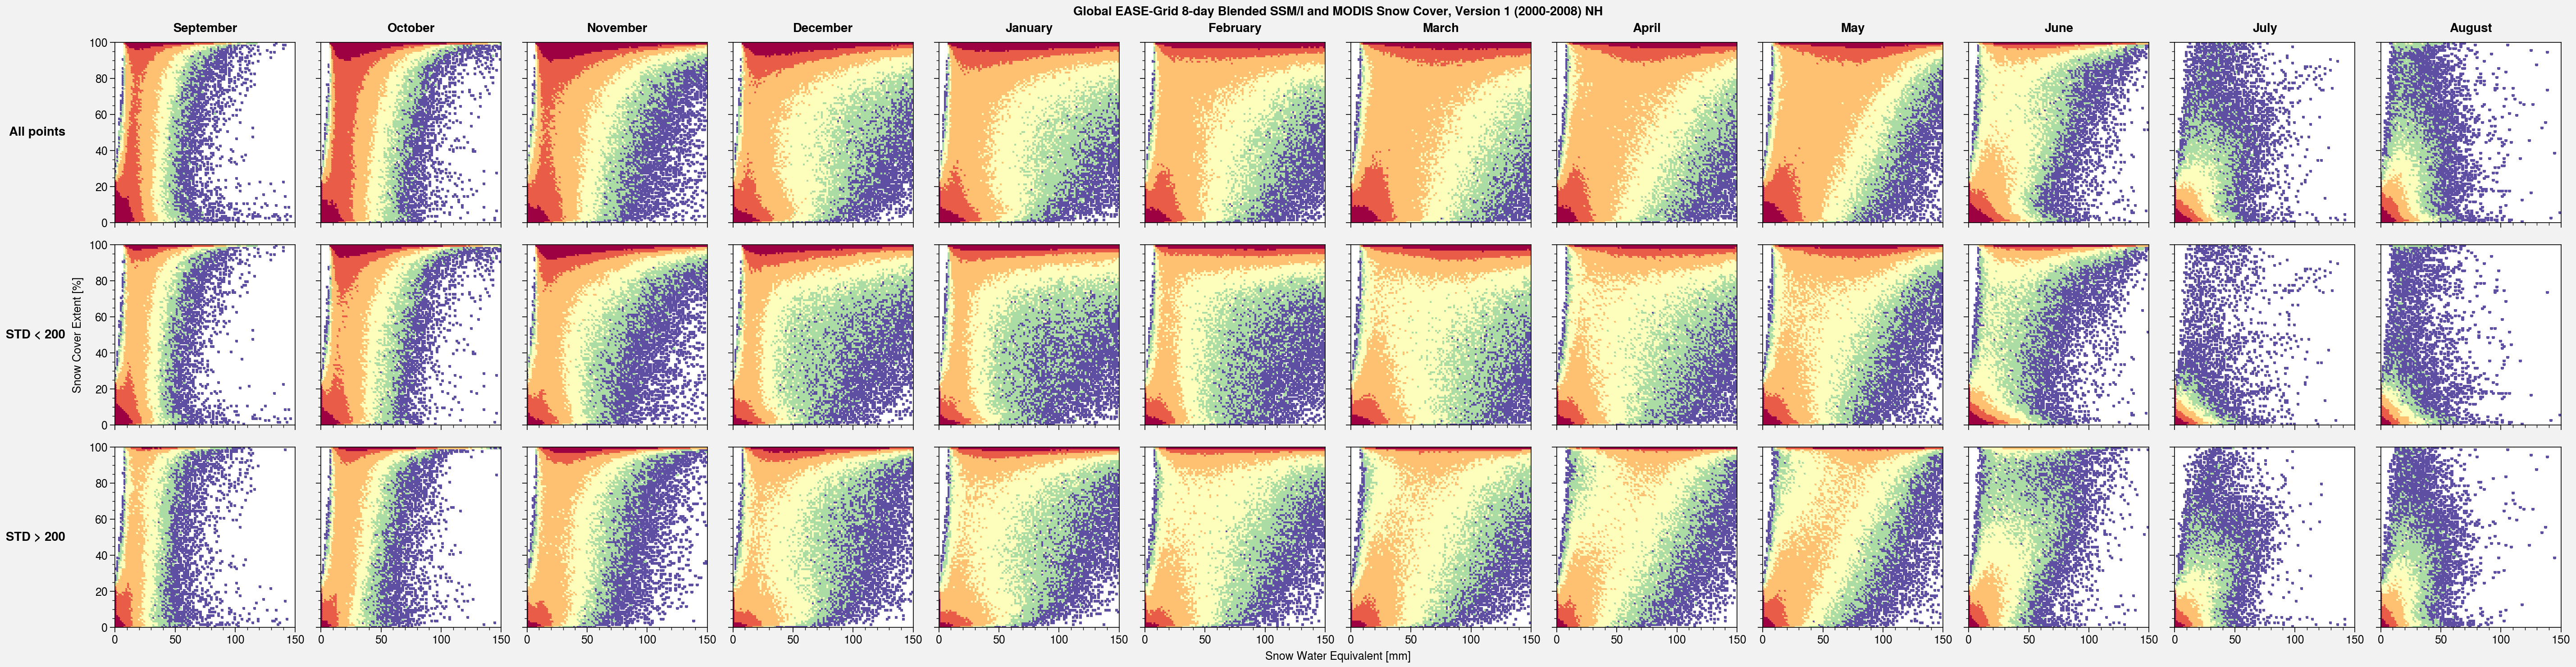

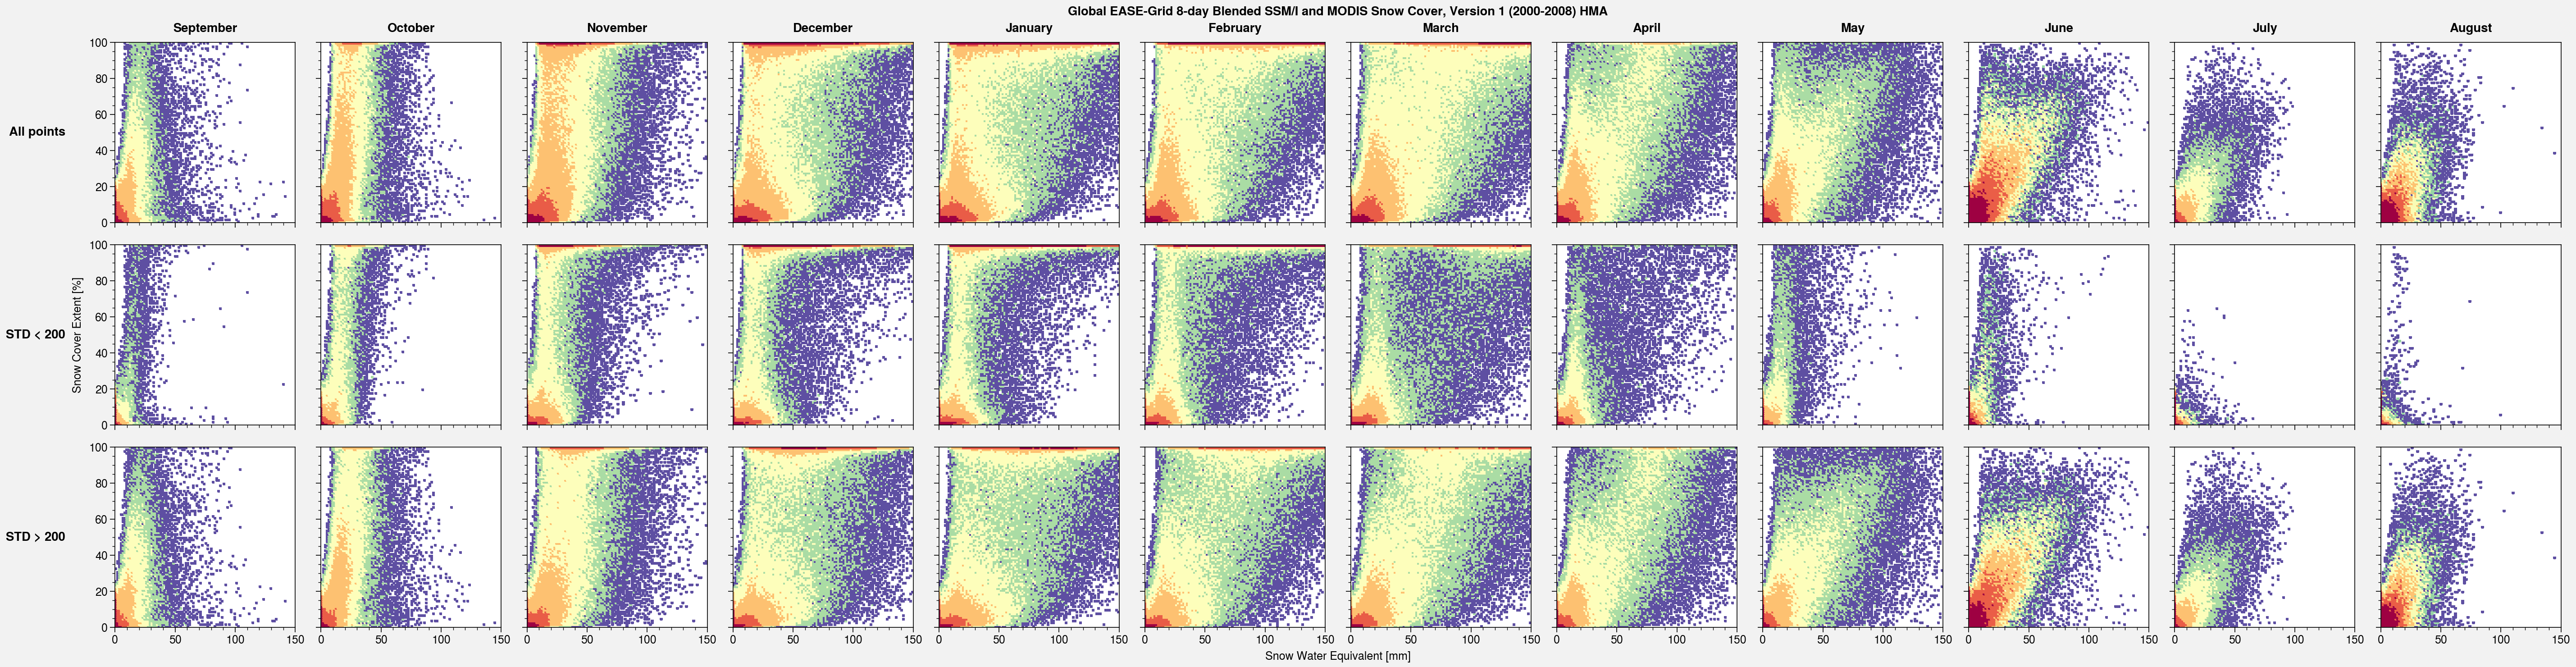

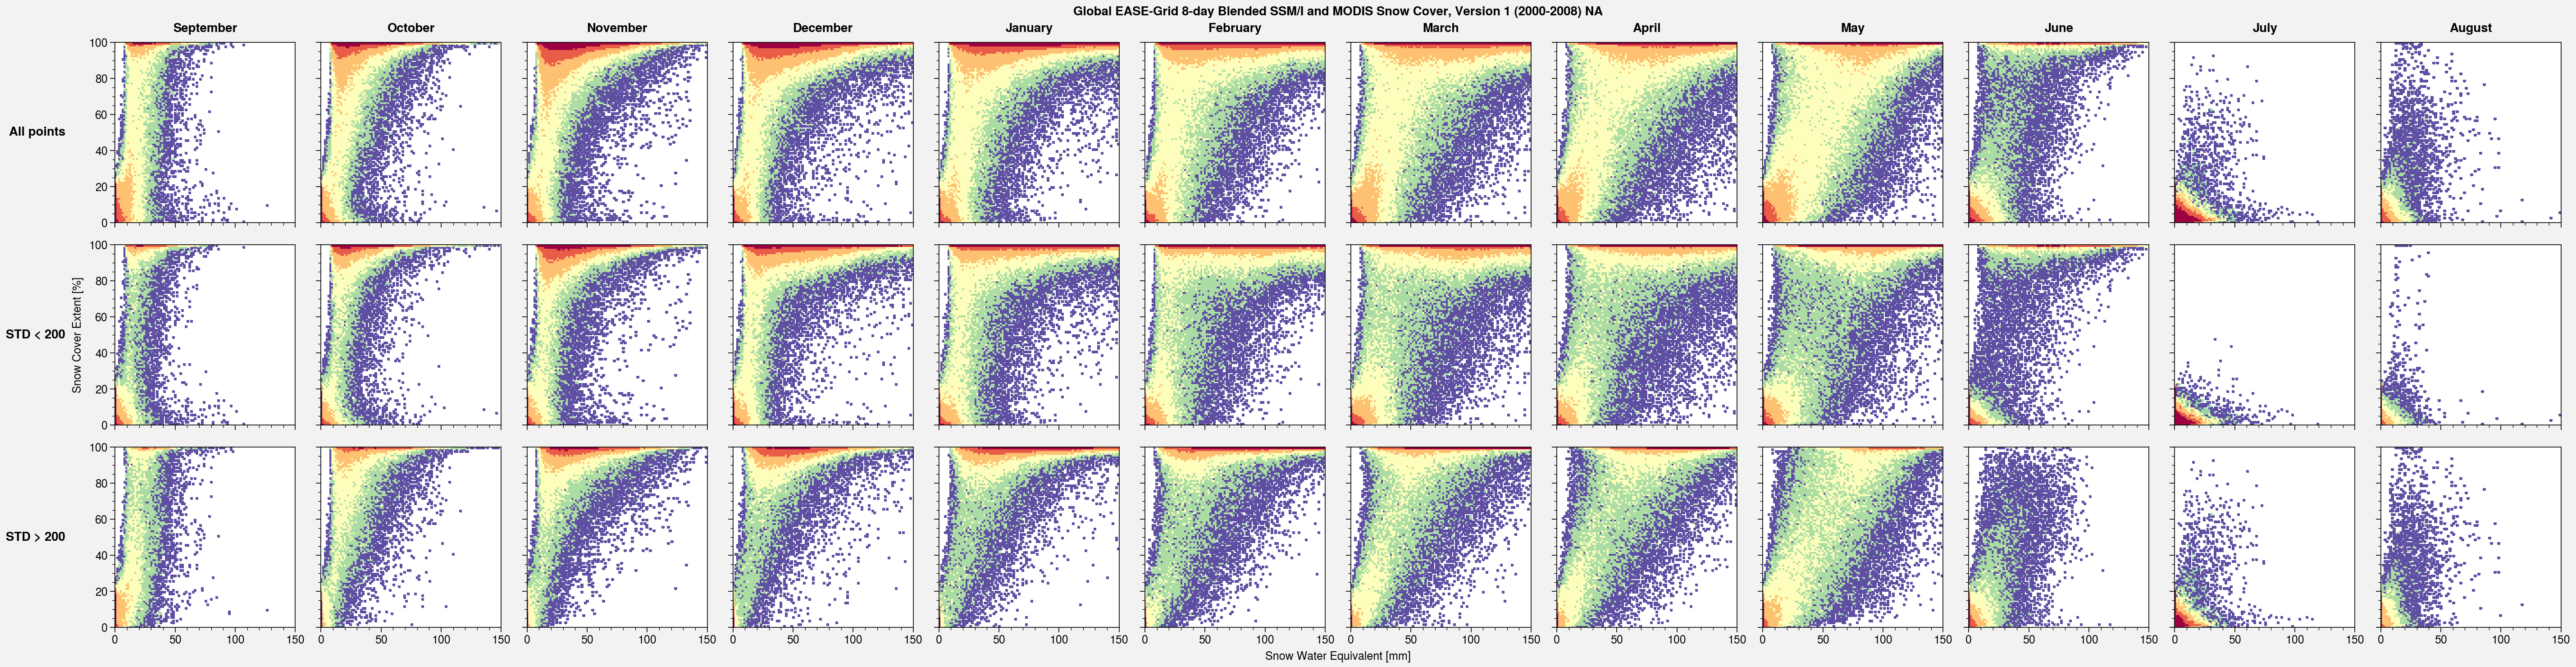

In [50]:
import calendar
months = np.array([9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]) # Start from begining snow season
lim_std = 200

xylim = [[0, 150], [0, 100]]
bins = 100
cmap = 'Spectral_r'
norm = 'log'
vmin=1
cmin=1

for domain in ['NH', 'HMA', 'NA']:
    latlim, lonlim = u.get_zone(domain)
    fig, axs = plot.subplots(nrows=3, ncols=months.size, axwidth=2)
    k = 0
    # All points
    for month in months:
        axs[k].hist2d(
            swe_regrid.sel(lat=latlim, lon=lonlim).where(swe_regrid['time.month'] == month, drop=True).values.flatten(), 
            scf_regrid.sel(lat=latlim, lon=lonlim).where(scf_regrid['time.month'] == month, drop=True).values.flatten(), 
            bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
        )
        k += 1
    # STD < 200
    for month in months:
        axs[k].hist2d(
            swe_regrid.sel(lat=latlim, lon=lonlim).where((swe_regrid['time.month'] == month) & (std < 200), drop=True).values.flatten(), 
            scf_regrid.sel(lat=latlim, lon=lonlim).where((scf_regrid['time.month'] == month) & (std < 200), drop=True).values.flatten(), 
            bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
        )
        k += 1
    # STD > 200
    for month in months:
        axs[k].hist2d(
            swe_regrid.sel(lat=latlim, lon=lonlim).where((swe_regrid['time.month'] == month) & (std > 200), drop=True).values.flatten(), 
            scf_regrid.sel(lat=latlim, lon=lonlim).where((scf_regrid['time.month'] == month) & (std > 200), drop=True).values.flatten(), 
            bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
        )
        k += 1

    axs.format(
        collabels=[calendar.month_name[month] for month in months],
        rowlabels=['All points', 'STD < '+str(lim_std), 'STD > '+str(lim_std)],
        xlabel='Snow Water Equivalent [mm]',
        ylabel='Snow Cover Extent [%]',
        suptitle='Global EASE-Grid 8-day Blended SSM/I and MODIS Snow Cover, Version 1 ' \
                 '('+str(ds.time['time.year'][0].values)+'-'+str(ds.time['time.year'][-1].values)+') ' + domain
    )

    filename = 'EASE-Grid_SCF-SWE_std_months_'+domain
    for ext in ['jpg', 'png', 'pdf']:
        fig.save('img/'+filename+'.'+ext)

## Monthly averaged

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


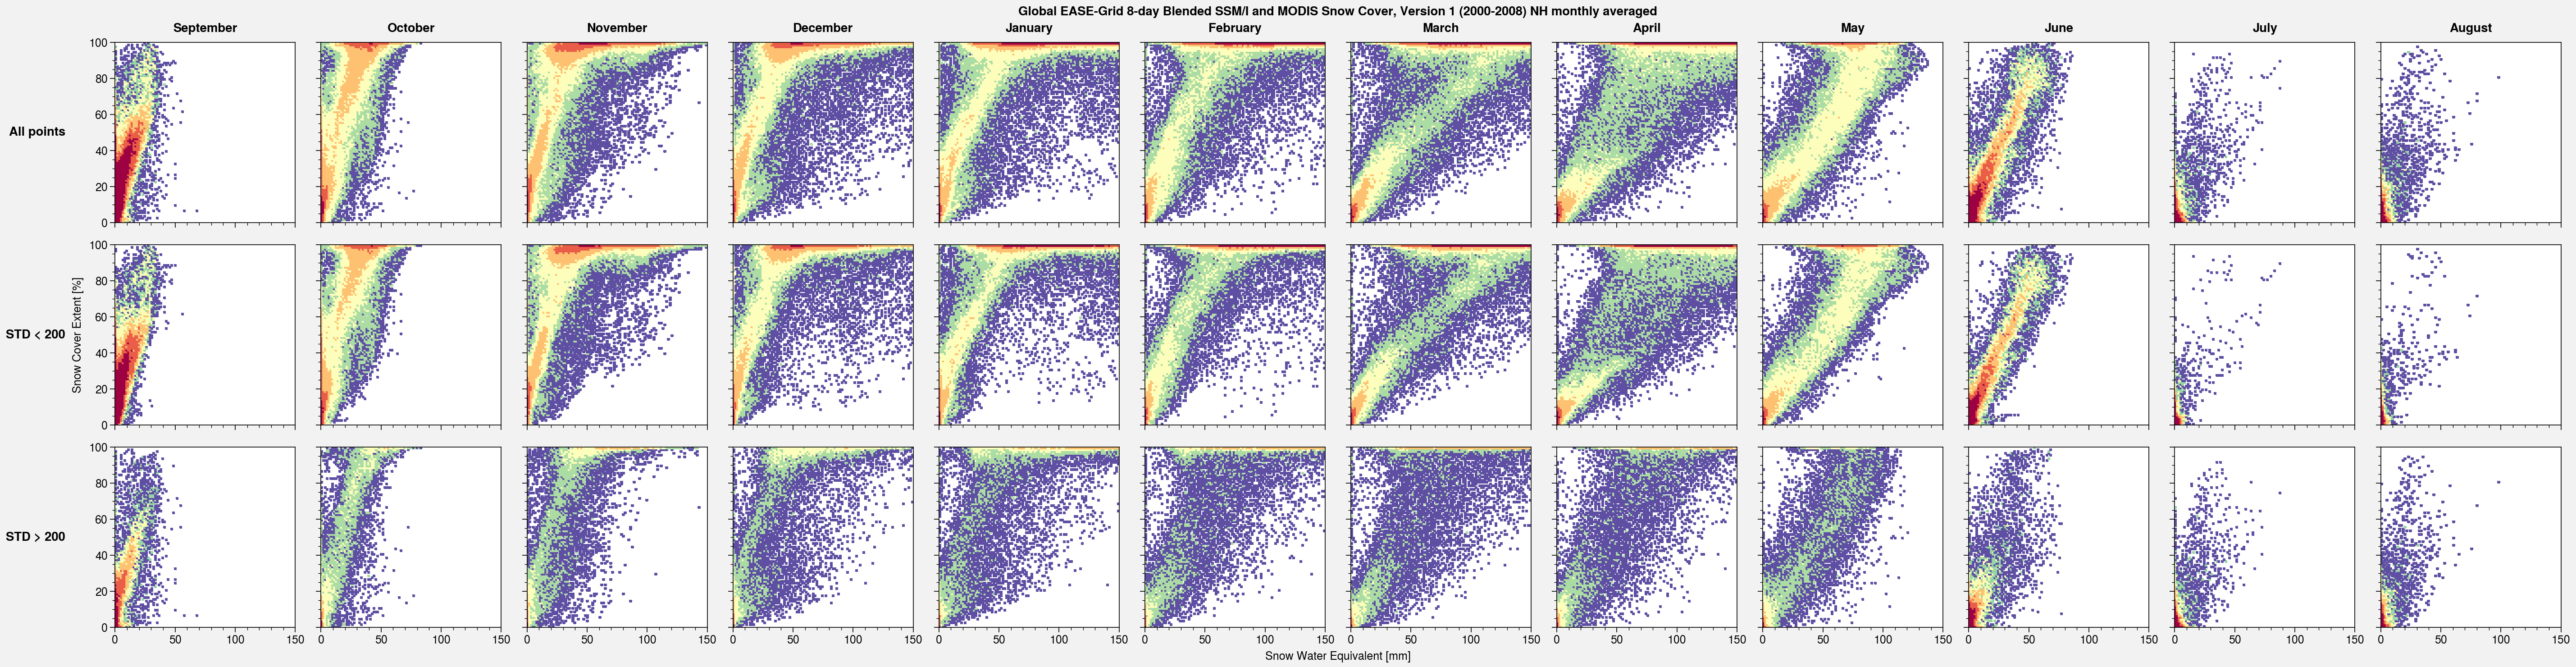

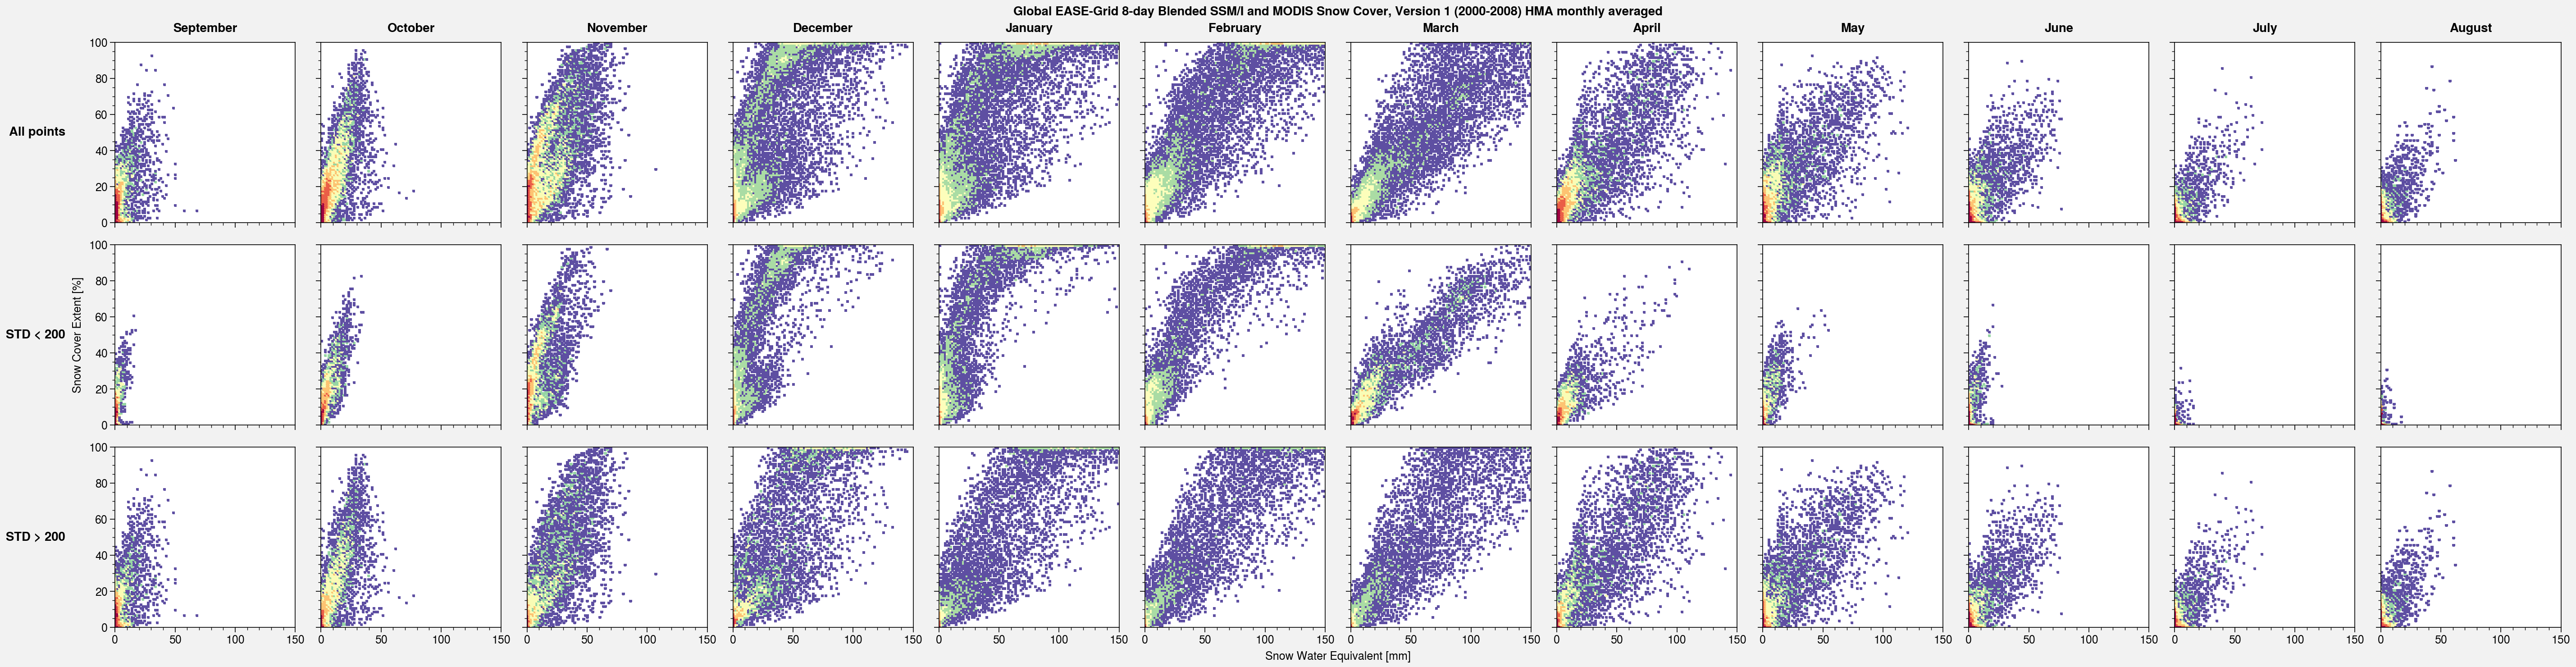

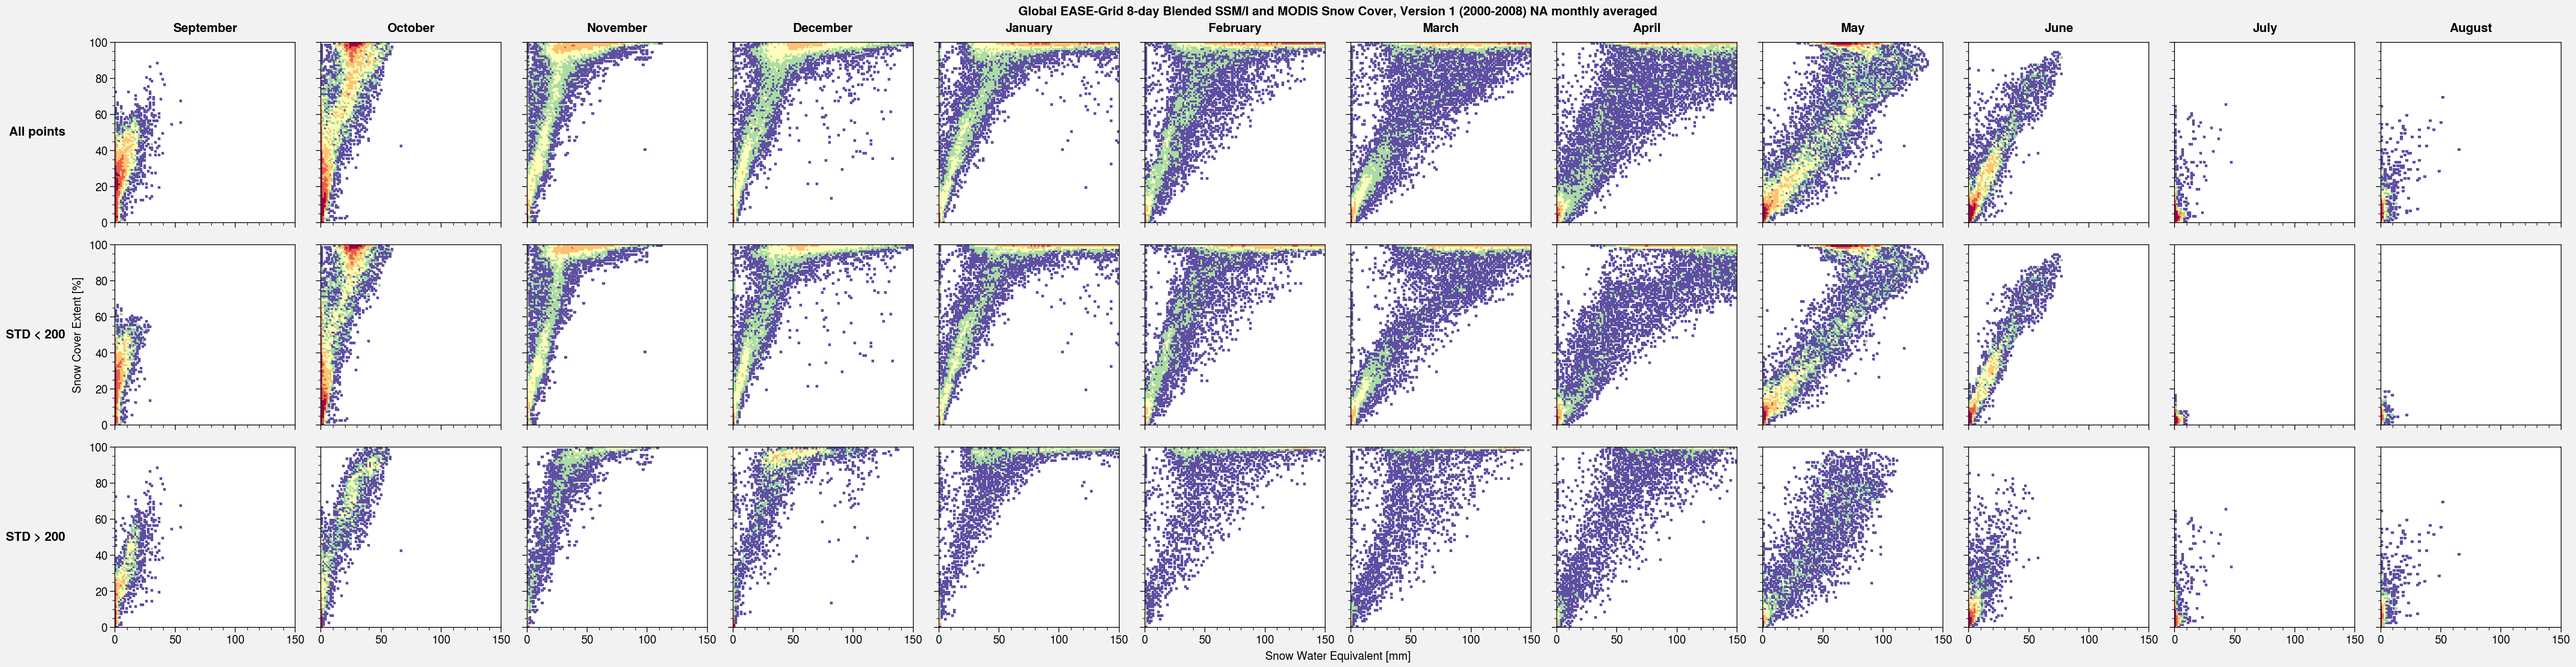

In [51]:
import calendar
months = np.array([9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]) # Start from begining snow season
lim_std = 200

xylim = [[0, 150], [0, 100]]
bins = 100
cmap = 'Spectral_r'
norm = 'log'
vmin=1
cmin=1

swe_regrid_month = swe_regrid.groupby('time.month').mean('time')
scf_regrid_month = scf_regrid.groupby('time.month').mean('time')

for domain in ['NH', 'HMA', 'NA']:
    latlim, lonlim = u.get_zone(domain)
    fig, axs = plot.subplots(nrows=3, ncols=months.size, axwidth=2)
    k = 0
    # All points
    for month in months:
        axs[k].hist2d(
            swe_regrid_month.sel(lat=latlim, lon=lonlim, month=month).values.flatten(), 
            scf_regrid_month.sel(lat=latlim, lon=lonlim, month=month).values.flatten(), 
            bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
        )
        k += 1
    # STD < 200
    for month in months:
        axs[k].hist2d(
            swe_regrid_month.sel(lat=latlim, lon=lonlim, month=month).where(std < 200, drop=True).values.flatten(), 
            scf_regrid_month.sel(lat=latlim, lon=lonlim, month=month).where(std < 200, drop=True).values.flatten(), 
            bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
        )
        k += 1
    # STD > 200
    for month in months:
        axs[k].hist2d(
            swe_regrid_month.sel(lat=latlim, lon=lonlim, month=month).where(std > 200, drop=True).values.flatten(), 
            scf_regrid_month.sel(lat=latlim, lon=lonlim, month=month).where(std > 200, drop=True).values.flatten(), 
            bins=bins, range=xylim, cmap=cmap, norm=norm, vmin=vmin, cmin=cmin
        )
        k += 1

    axs.format(
        collabels=[calendar.month_name[month] for month in months],
        rowlabels=['All points', 'STD < '+str(lim_std), 'STD > '+str(lim_std)],
        xlabel='Snow Water Equivalent [mm]',
        ylabel='Snow Cover Extent [%]',
        suptitle='Global EASE-Grid 8-day Blended SSM/I and MODIS Snow Cover, Version 1 ' \
                 '('+str(ds.time['time.year'][0].values)+'-'+str(ds.time['time.year'][-1].values)+') ' + domain + ' monthly averaged'
    )

    filename = 'EASE-Grid_SCF-SWE_std_months-averaged_'+domain
    for ext in ['jpg', 'png', 'pdf']:
        fig.save('img/'+filename+'.'+ext)